# Life-time Broadened Case

This is the code for the cold vapor cell. In this code, the decay from states 1 and 2 is set to 0 but can be modified.

### Libraries

In [1]:
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Image
from scipy.linalg import LinAlgError, solve

### Parameters

In [28]:
Transparency_Omega_1 = None
Transparency_Omega_2 = None
Om_2_list_adapted = None

# Constants
epsilon_0 = 8.854e-12  # Vacuum permittivity (F/m)
hbar = 1.054e-34       # Reduced Planck's constant (J·s)
mu_13 = 1.366e-29     # Dipole moment between states (|1> and |3>) (C·m)
mu_23 = 1.058e-29     # Dipole moment between states (|2> and |3>) (C·m)
c = 3e8

Gamma3 = 2 * np.pi * 6   # (MHz)
Gamma31 = 0.5 * Gamma3   # Decay from level 3 to level 1 (MHz)
Gamma32 = Gamma23 = 0.5 * Gamma3   # Decay from level 3 to level 2 (MHz)
Gamma12 = Gamma21 = 0.05 * Gamma3    # Decay rates between levels 1 and 2 (MHz)
gamma13 = (Gamma3 + Gamma12)/2  # Decoherence rate between levels 1 and 3 (MHz)
gamma23 = (Gamma3 + Gamma21)/2  # Decoherence rate between levels 2 and 3 (MHz)
gamma12 = (Gamma12 + Gamma21)/2   # Decoherence rate between ground states (MHz)

w_1 = 2 * np.pi * 3.771120414e14
w_2 = 2 * np.pi * 3.771052067e14
k_1 = w_1 / 3e8
k_2 = w_2 / 3e8
L = 0.02        # Length in meters
z = 0.0001    # Step size in meters

OD_0 = 50
N = OD_0 / ((4 * np.pi * mu_13**2 * L) / (Gamma3 * 10**6 * hbar * epsilon_0 * 795e-9))

print("Atomic Density (OD0={:.2f}) = {:.2e}".format(OD_0, N))

Atomic Density (OD0=50.00) = 2.98e+16


## Main Code

FloatSlider(value=0.1, description='$\\Omega_1$ (MHz)', layout=Layout(width='800px'), max=500.0, min=1e-09, st…

FloatSlider(value=0.0, description='$\\Delta_1$ (MHz)', layout=Layout(width='800px'), max=150.0, min=-50.0, st…

FloatSlider(value=0.0, description='$\\Delta_2$ (MHz)', layout=Layout(width='800px'), max=150.0, min=-50.0, st…

Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

Processing z step 50/200
Processing z step 100/200
Processing z step 150/200
Power required = 3.43e-06 W


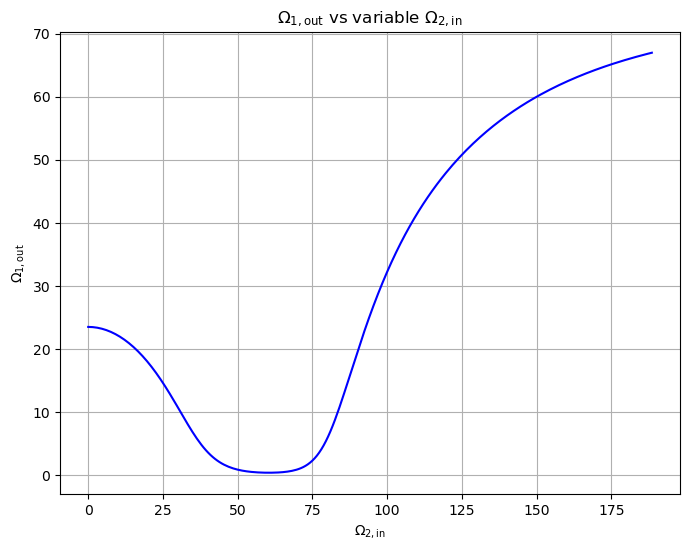

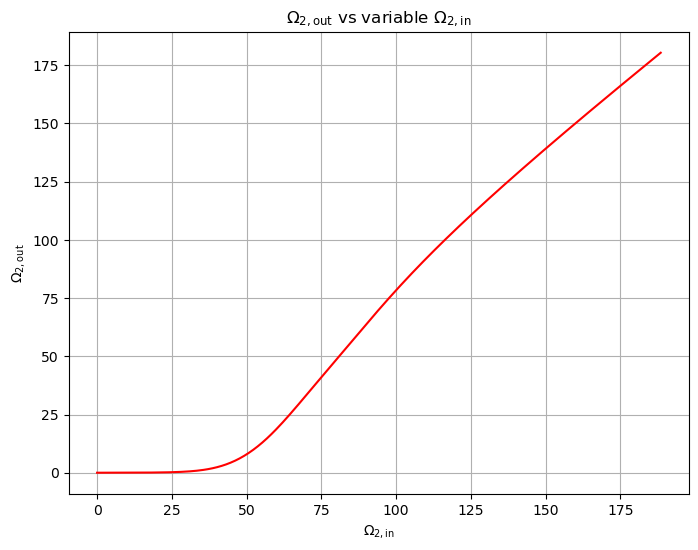

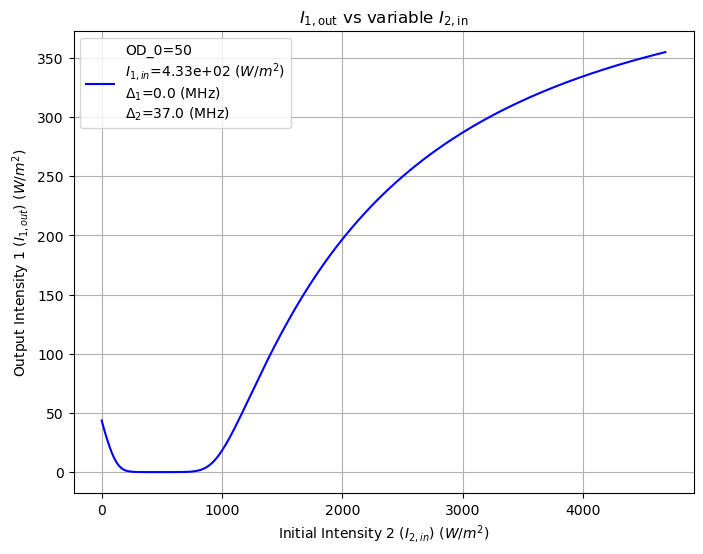

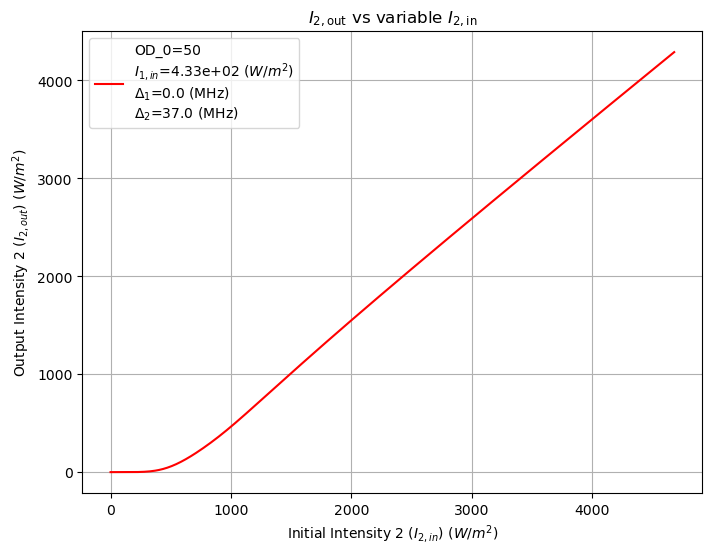

Processing z step 50/200
Processing z step 100/200
Processing z step 150/200
Power required = 3.43e-06 W


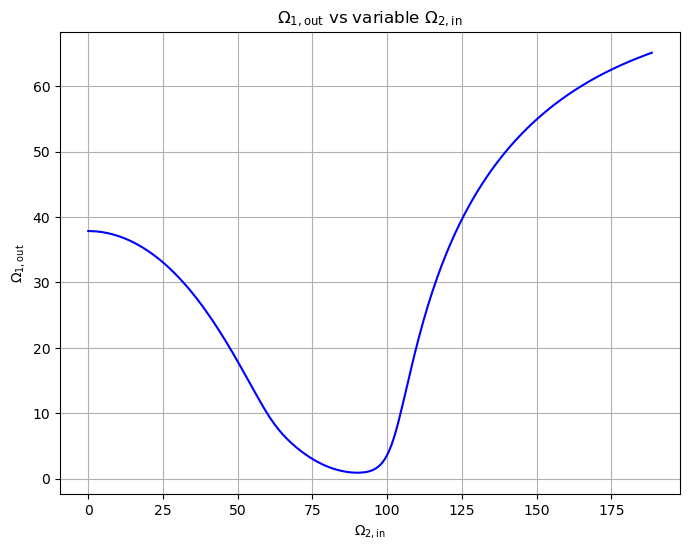

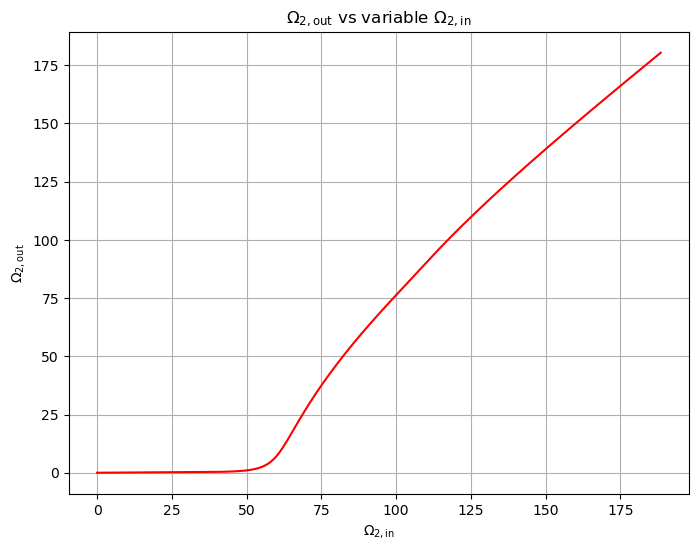

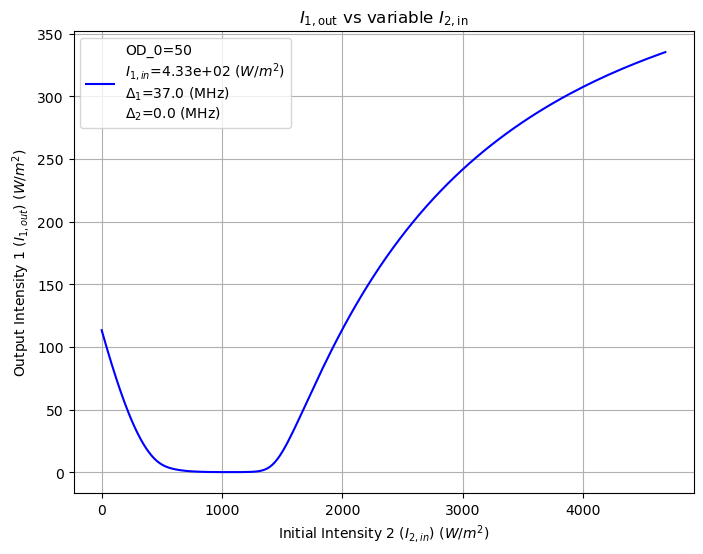

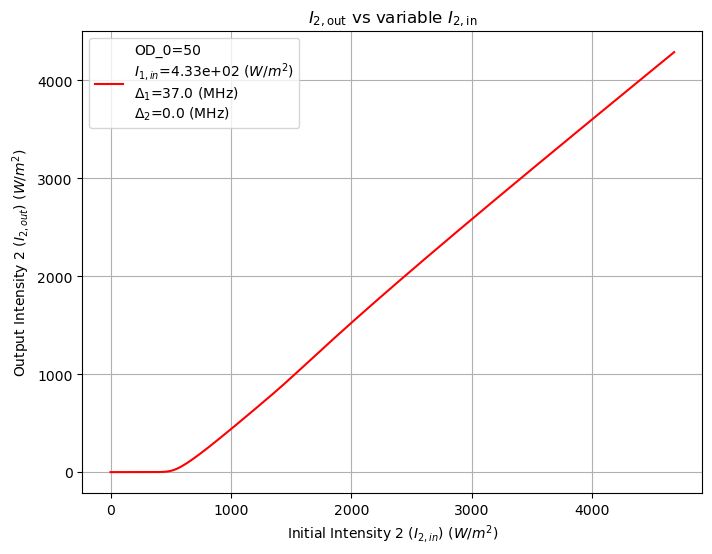

In [29]:
# Backend function to calculate OD based on user input
def calculate_OD_1(Om_1=1.0, delta_1=0.0, delta_2=0.0):
    n_rabi = 250
    Om_2_list_adapted = np.linspace(0.001, 5 * Gamma3, n_rabi, dtype=complex)  # Coupling Rabi frequency range (MHz)
    Om_2_list = Om_2_list_adapted.copy()
    Om_1_list = np.full(n_rabi, Om_1, dtype=complex)
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = np.zeros((nz, n_rabi), dtype=complex)
    Om_1_vs_z = np.zeros((nz, n_rabi), dtype=complex)

    # Initialize arrays with zeros to store populations
    rho11_values = np.zeros((nz, n_rabi), dtype=float)
    rho22_values = np.zeros((nz, n_rabi), dtype=float)
    rho33_values = np.zeros((nz, n_rabi), dtype=float)

    # Initialize arrays to store rho31 and rho32
    rho31_values = np.zeros((nz, n_rabi), dtype=complex)
    rho32_values = np.zeros((nz, n_rabi), dtype=complex)
    
    Om_2_actual = 0 + 0*1j
    Om_1_actual = 0 + 0*1j

    for i in range(nz):
        if i == nz/4 or i == nz/2 or i == 3*nz/4: 
            print(f"Processing z step {i}/{nz}")
        
        for j in range(0, len(Om_2_list)):
            
            Om_2_actual = Om_2_list[j]     
            Om_1_actual = Om_1_list[j]      

            delta_1_actual = delta_1
            delta_2_actual = delta_2

            # Construct A and b to compute matrix linear solution
            # Define the imaginary unit
            I = 1j

            # Construct the matrix A
            A = np.array([
                # Row 1
                [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
                # Row 2
                [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                # Row 3
                [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                # Row 4
                [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                # Row 5
                [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                # Row 6
                [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                # Row 7
                [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                # Row 8
                [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
            ], dtype=complex)
            
            # Construct the vector b
            b = np.array([
                Gamma31,
                0,
                I*np.conjugate(Om_1_actual)/2,
                0,
                Gamma32,
                I*np.conjugate(Om_2_actual)/2,
                -I*Om_1_actual/2,
                -I*Om_2_actual/2
            ], dtype=complex)
            
            # Solve the linear system A * v = b
            cond_number = np.linalg.cond(A)
            if cond_number > 1e12:
                print("Matrix is ill-conditioned")
            try:
                v = solve(A, b)
            except LinAlgError:
                # Handle singular matrix
                print("nan")
                rho11_values[i][j] = np.nan
                rho22_values[i][j] = np.nan
                rho33_values[i][j] = np.nan
                rho31_values[i][j] = np.nan
                rho32_values[i][j] = np.nan
                continue


            # Extract the solutions
            rho11 = np.real(v[0])
            rho12 = v[1]
            rho13 = v[2]
            rho21 = v[3]
            rho22 = np.real(v[4])
            rho23 = v[5]
            rho31 = v[6]
            rho32 = v[7]

            # Compute rho33
            rho33 = 1 - rho11 - rho22

            # Store the populations
            rho11_values[i][j] = rho11
            rho22_values[i][j] = rho22
            rho33_values[i][j] = rho33
            rho31_values[i][j] = rho31
            rho32_values[i][j] = rho32
                     
                        
            # Update the Rabi frequencies
            Om_1_list[j] = Om_1_actual + z * (1j) * (k_1 / (epsilon_0 * hbar)) * N * rho31 * mu_13**2 / 1e6
            Om_2_list[j] = Om_2_actual + z * (1j) * (k_2 / (epsilon_0 * hbar)) * N * rho32 * mu_23**2 / 1e6
        

        # Record Rabi frequencies at this z step
        Om_1_vs_z[i] = Om_1_list.copy()
        Om_2_vs_z[i] = Om_2_list.copy()
    
    # Convert lists to numpy arrays
    Om_1_vs_z = np.array(Om_1_vs_z)  # Shape: (nz, n_rabi)
    Om_2_vs_z = np.array(Om_2_vs_z)  # Shape: (nz, n_rabi)
    
    return Om_2_list, Om_1_list, rho11_values, rho22_values, rho33_values, rho31_values, rho32_values, Om_2_vs_z, Om_1_vs_z, z_array, Om_2_list_adapted

def plot_OD(Om_1, delta_1, delta_2):
    global Transparency_Omega_1, Transparency_Omega_2, Om_2_list_adapted
    Om_2_list, Om_1_list, rho11_values, rho22_values, rho33_values, rho31_values, rho32_values, Om_2_vs_z, Om_1_vs_z, z_array, Om_2_list_adapted = calculate_OD_1(Om_1, delta_1, delta_2)
    
    # Calculate Power of I_1
    w0 = 71e-6          # In m
    P = (np.pi * c * epsilon_0 * (Om_1*1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)
    print("Power required = {:.2e} W".format(P))
    
    # Calculate input and output intensity
    Input_Intensity_Omega_1 = 0.5 * c * epsilon_0 * (Om_1 * 1e6 * hbar / mu_13)**2
    Input_Intensity_Omega_2 = 0.5 * c * epsilon_0 * (Om_2_list_adapted * 1e6 * hbar / mu_23)**2  

    Output_Intensity_Omega_1 = 0.5 * c * epsilon_0 * (np.abs(Om_1_vs_z[-1, :]) * 1e6 * hbar / mu_13)**2
    Output_Intensity_Omega_2 = 0.5 * c * epsilon_0 * (np.abs(Om_2_vs_z[-1, :]) * 1e6 * hbar / mu_23)**2  
    
    ###############
    
    # Plot Output Intensity of Omega_1 vs Initial Omega_1
    plt.figure(figsize=(8, 6))
    plt.plot(np.real(Om_2_list_adapted), np.abs(Om_1_vs_z[-1, :]), color='blue', label='Output Intensity $\Omega_1$')
    plt.xlabel('$\Omega_{2,\mathrm{in}}$')
    plt.ylabel('$\Omega_{1,\mathrm{out}}$')
    plt.title('$\Omega_{1,\mathrm{out}}$ vs variable $\Omega_{2,\mathrm{in}}$')
    plt.grid(True)
    plt.show()

    # Plot Output Intensity of Omega_2 vs Initial Omega_1
    plt.figure(figsize=(8, 6))
    plt.plot(np.real(Om_2_list_adapted), np.abs(Om_2_vs_z[-1, :]), color='red', label='Output Intensity $\Omega_2$')
    plt.xlabel('$\Omega_{2,\mathrm{in}}$')
    plt.ylabel('$\Omega_{2,\mathrm{out}}$')
    plt.title('$\Omega_{2,\mathrm{out}}$ vs variable $\Omega_{2,\mathrm{in}}$')
    plt.grid(True)
    plt.show()
    
    ##############
    
    # Plot Output Intensity 1 vs Initial Intensity 2
    plt.figure(figsize=(8, 6))
    plt.plot(Input_Intensity_Omega_2, Output_Intensity_Omega_1, color='blue', label=f'OD_0={OD_0}\n$I_{{1,\t{{in}}}}$={Input_Intensity_Omega_1:.2e} $(W/m^2)$\n$\\Delta_1$={delta_1} (MHz)\n$\\Delta_2$={delta_2} (MHz)')
    plt.xlabel('Initial Intensity 2 ($I_{{2,\t{{in}}}}$) $(W/m^2)$')
    plt.ylabel('Output Intensity 1 ($I_{{1,\t{{out}}}}$) $(W/m^2)$')
    plt.title('$I_{1,\mathrm{out}}$ vs variable $I_{2,\mathrm{in}}$')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot Output Intensity 2 vs Initial Intensity 2
    plt.figure(figsize=(8, 6))
    plt.plot(Input_Intensity_Omega_2, Output_Intensity_Omega_2, color='red', label=f'OD_0={OD_0}\n$I_{{1,\t{{in}}}}$={Input_Intensity_Omega_1:.2e} $(W/m^2)$\n$\\Delta_1$={delta_1} (MHz)\n$\\Delta_2$={delta_2} (MHz)')
    plt.xlabel('Initial Intensity 2 ($I_{{2,\t{{in}}}}$) $(W/m^2)$')
    plt.ylabel('Output Intensity 2 ($I_{{2,\t{{out}}}}$) $(W/m^2)$')
    plt.title('$I_{2,\mathrm{out}}$ vs variable $I_{2,\mathrm{in}}$')
    plt.grid(True)
    plt.legend()
    plt.show()
    
# Adjust slider description width specifically
slider_layout = widgets.Layout(width='800px')  # Adjust slider width if needed
description_layout = widgets.Layout(width='150px')  # Adjust description width

# Interactive sliders for Om_1, delta_1, delta_2 with wider description layout
Om_1_slider = widgets.FloatSlider(
    value=0.1, min=0.000000001, max=500.0, step=0.01,
    description='$\Omega_1$ (MHz)', layout=slider_layout,
    style={'description_width': '150px'}  # This sets description width
)

delta_1_slider = widgets.FloatSlider(
    value=0.0, min=-50, max=150, step=0.01,
    description='$\Delta_1$ (MHz)', layout=slider_layout,
    style={'description_width': '150px'}  # Adjust description width
)

delta_2_slider = widgets.FloatSlider(
    value=0.0, min=-50, max=150, step=0.01,
    description='$\Delta_2$ (MHz)', layout=slider_layout,
    style={'description_width': '150px'}  # Adjust description width
)

# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values
    Om_1 = Om_1_slider.value
    delta_1 = delta_1_slider.value
    delta_2 = delta_2_slider.value
    
    # Call the plot_OD function with these values
    plot_OD(Om_1, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the sliders and the button
display(Om_1_slider, delta_1_slider, delta_2_slider, run_button)


### Scanning Values

Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

Processing z step 50/200
Processing z step 100/200
Processing z step 150/200
Processing z step 50/200
Processing z step 100/200
Processing z step 150/200
Processing z step 50/200
Processing z step 100/200
Processing z step 150/200
Processing z step 50/200
Processing z step 100/200
Processing z step 150/200
Processing z step 50/200
Processing z step 100/200
Processing z step 150/200


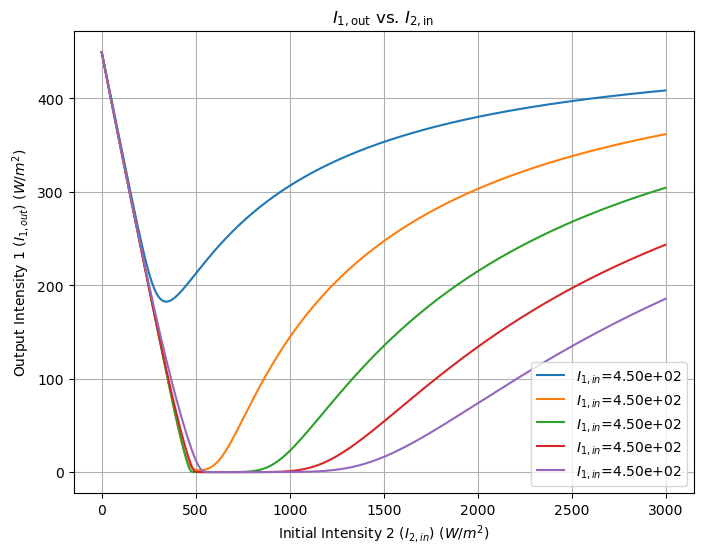

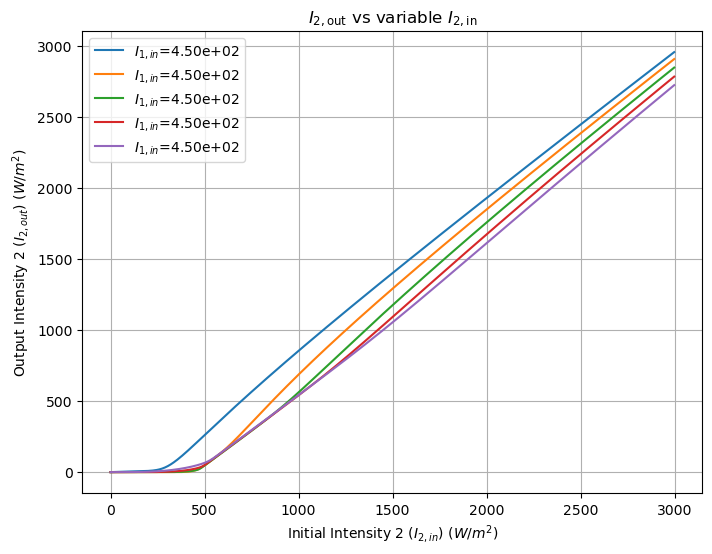

In [27]:
# Backend function to calculate OD based on user input
def calculate_OD_1(Om_1=1.0, delta_1=0.0, delta_2=0.0):
    n_rabi = 500
    Om_2_list_adapted = np.linspace(0, 4 * Gamma3, n_rabi, dtype=complex)  # Coupling Rabi frequency range (MHz)
    Om_2_list = Om_2_list_adapted.copy()
    Om_1_list = np.full(n_rabi, Om_1, dtype=complex)
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = np.zeros((nz, n_rabi), dtype=complex)
    Om_1_vs_z = np.zeros((nz, n_rabi), dtype=complex)

    # Initialize arrays with zeros to store populations
    rho11_values = np.zeros((nz, n_rabi), dtype=float)
    rho22_values = np.zeros((nz, n_rabi), dtype=float)
    rho33_values = np.zeros((nz, n_rabi), dtype=float)

    # Initialize arrays to store rho31 and rho32
    rho31_values = np.zeros((nz, n_rabi), dtype=complex)
    rho32_values = np.zeros((nz, n_rabi), dtype=complex)
    
    Om_2_actual = 0 + 0*1j
    Om_1_actual = 0 + 0*1j

    for i in range(nz):
        if i == nz/4 or i == nz/2 or i == 3*nz/4: 
            print(f"Processing z step {i}/{nz}")
        
        for j in range(0, len(Om_2_list)):
            
            Om_2_actual = Om_2_list[j]     
            Om_1_actual = Om_1_list[j]      

            delta_1_actual = delta_1
            delta_2_actual = delta_2

            # Construct A and b to compute matrix linear solution
            # Define the imaginary unit
            I = 1j

            # Construct the matrix A
            A = np.array([
                # Row 1
                [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
                # Row 2
                [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                # Row 3
                [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                # Row 4
                [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                # Row 5
                [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                # Row 6
                [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                # Row 7
                [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                # Row 8
                [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
            ], dtype=complex)
            
            # Construct the vector b
            b = np.array([
                Gamma31,
                0,
                I*np.conjugate(Om_1_actual)/2,
                0,
                Gamma32,
                I*np.conjugate(Om_2_actual)/2,
                -I*Om_1_actual/2,
                -I*Om_2_actual/2
            ], dtype=complex)
            
            # Solve the linear system A * v = b
            cond_number = np.linalg.cond(A)
            if cond_number > 1e12:
                print("Matrix is ill-conditioned")
            try:
                v = solve(A, b)
            except LinAlgError:
                # Handle singular matrix
                print("nan")
                rho11_values[i][j] = np.nan
                rho22_values[i][j] = np.nan
                rho33_values[i][j] = np.nan
                rho31_values[i][j] = np.nan
                rho32_values[i][j] = np.nan
                continue


            # Extract the solutions
            rho11 = np.real(v[0])
            rho12 = v[1]
            rho13 = v[2]
            rho21 = v[3]
            rho22 = np.real(v[4])
            rho23 = v[5]
            rho31 = v[6]
            rho32 = v[7]

            # Compute rho33
            rho33 = 1 - rho11 - rho22

            # Store the populations
            rho11_values[i][j] = rho11
            rho22_values[i][j] = rho22
            rho33_values[i][j] = rho33
            rho31_values[i][j] = rho31
            rho32_values[i][j] = rho32
                     
                        
            # Update the Rabi frequencies
            Om_1_list[j] = Om_1_actual + z * (1j) * (k_1 / (epsilon_0 * hbar)) * N * rho31 * mu_13**2 / 1e6
            Om_2_list[j] = Om_2_actual + z * (1j) * (k_2 / (epsilon_0 * hbar)) * N * rho32 * mu_23**2 / 1e6
        

        # Record Rabi frequencies at this z step
        Om_1_vs_z[i] = Om_1_list.copy()
        Om_2_vs_z[i] = Om_2_list.copy()
    
    # Convert lists to numpy arrays
    Om_1_vs_z = np.array(Om_1_vs_z)  # Shape: (nz, n_rabi)
    Om_2_vs_z = np.array(Om_2_vs_z)  # Shape: (nz, n_rabi)
    
    return Om_2_list, Om_1_list, rho11_values, rho22_values, rho33_values, rho31_values, rho32_values, Om_2_vs_z, Om_1_vs_z, z_array, Om_2_list_adapted

def plot_OD(Om_1, delta_1, delta_2):
    
    Output_Intensity_Omega_1_list = [0]*len(delta_1)
    Output_Intensity_Omega_2_list = [0]*len(delta_1)
    Input_Intensity_Omega_1_list = [0]*len(delta_1)
    Input_Intensity_Omega_2_list = [0]*len(delta_1)
        
    # Calculate Power of I_1
    #w0 = 71e-6          # In m
    #P = (np.pi * c * epsilon_0 * (Om_1*1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)
    #print("Power required = {:.2e} W".format(P))
    
    for i in range(len(delta_1)):    
        Om_2_list, Om_1_list, rho11_values, rho22_values, rho33_values, rho31_values, rho32_values, Om_2_vs_z, Om_1_vs_z, z_array, Om_2_list_adapted = calculate_OD_1(Om_1[i], delta_1[i], delta_2[i])
        # Calculate input and output intensity
        Input_Intensity_Omega_1 = 0.5 * c * epsilon_0 * (Om_1[i] * 1e6 * hbar / mu_13)**2
        Input_Intensity_Omega_2 = 0.5 * c * epsilon_0 * (Om_2_list_adapted * 1e6 * hbar / mu_23)**2  

        Output_Intensity_Omega_1 = 0.5 * c * epsilon_0 * (np.abs(Om_1_vs_z[-1, :]) * 1e6 * hbar / mu_13)**2
        Output_Intensity_Omega_2 = 0.5 * c * epsilon_0 * (np.abs(Om_2_vs_z[-1, :]) * 1e6 * hbar / mu_23)**2  
        
        Input_Intensity_Omega_1_list[i] = Input_Intensity_Omega_1
        Input_Intensity_Omega_2_list[i] = Input_Intensity_Omega_2
        
        Output_Intensity_Omega_1_list[i] = Output_Intensity_Omega_1
        Output_Intensity_Omega_2_list[i] = Output_Intensity_Omega_2
    
    # Plot Output Intensity 1 vs Initial Intensity 2
    plt.figure(figsize=(8, 6))
    for i in range(len(delta_1)):
        plt.plot(Input_Intensity_Omega_2, Output_Intensity_Omega_1_list[i], label=f'$I_{{1,\t{{in}}}}$={Input_Intensity_Omega_1_list[i]:.2e}')
    plt.xlabel('Initial Intensity 2 ($I_{{2,\t{{in}}}}$) $(W/m^2)$')
    plt.ylabel('Output Intensity 1 ($I_{{1,\t{{out}}}}$) $(W/m^2)$')
    plt.title(r'$I_{1,\mathrm{out}}$ vs. $I_{2,\mathrm{in}}$')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot Output Intensity 2 vs Initial Intensity 2
    plt.figure(figsize=(8, 6))
    for i in range(len(delta_1)):
        plt.plot(Input_Intensity_Omega_2, Output_Intensity_Omega_2_list[i], label=f'$I_{{1,\t{{in}}}}$={Input_Intensity_Omega_1_list[i]:.2e}')
    plt.xlabel('Initial Intensity 2 ($I_{{2,\t{{in}}}}$) $(W/m^2)$')
    plt.ylabel('Output Intensity 2 ($I_{{2,\t{{out}}}}$) $(W/m^2)$')
    plt.title('$I_{2,\mathrm{out}}$ vs variable $I_{2,\mathrm{in}}$')
    plt.grid(True)
    plt.legend()
    plt.show()

# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values
    Om_1 = np.array([2, 2, 2, 2, 2])*Gamma3
    delta_1 = [0, 0, 0, 0, 0]
    delta_2 = Om_1/2
    
    # Call the plot_OD function with these values
    plot_OD(Om_1, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the sliders and the button
display(run_button)